# Initial Set Up

In [1]:
#----------------------------------------------------------------------
    # Libraries
#----------------------------------------------------------------------

import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import datetime as dt
import requests
import zipfile
import io
import os

In [2]:
#----------------------------------------------------------------------
    # Constants for all portfolios
#----------------------------------------------------------------------

# start and end dates of observed
startDate = '2018-01-05'
# sets the start date to the nearest monday to make aligining data easier
startDate = pd.to_datetime(startDate) - pd.offsets.Week(weekday=0)
endDate = '2024-10-01'
testLength = 156

# set the initial budget to invest
initialVal = 100000

# set the length of investment period (in weeks)
investPeriod = 26

In [3]:
#----------------------------------------------------------------------
    # Finding adj close data
#----------------------------------------------------------------------

# function to find the adj close data for the given tickers and time period
def find_adj_close(tickers, startDate, endDate):
    # pull data from yfinance
    adjClose = yf.download(tickers, start=startDate, end=endDate, interval = '1wk')['Adj Close']

    # format the data to work with the optimization structure
    adjClose.reset_index(inplace=True)
    # title the date column
    adjClose.columns = ['Date'] + tickers
    # format the date column
    adjClose['Date'] = adjClose['Date'].dt.strftime('%Y-%m-%d')

    # set date as the index
    adjClose.set_index('Date', inplace=True)

    # set the dates to pandas dates
    adjClose.index = pd.to_datetime(adjClose.index)

    # define the tickers off adjClose so it's compatible later
    tickers = adjClose.columns

    return adjClose, tickers

In [4]:
#----------------------------------------------------------------------
    # Finding factor returns
#----------------------------------------------------------------------

# function to find the factor return data for the given tickers and time period
def find_factor_ret(startDate, endDate):
    # URLs for factor data
    fiveFactorURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_TXT.zip'
    momURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_daily_TXT.zip'
    STRevURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_ST_Reversal_Factor_daily_TXT.zip'
    LTRevURL = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_LT_Reversal_Factor_daily_TXT.zip'

    # function to pull factor data from the web
    def pull_factor_data(url, skipRows):
        response = requests.get(url)
        # pull the data from the site
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # get the name of the file
            fileName = z.namelist()[0]
        
            # read the .txt file
            with z.open(fileName) as file:
                return pd.read_csv(file, skiprows=skipRows, encoding='ISO-8859-1',  sep='\\s+', on_bad_lines='skip')

    # pulling from Ken French database
    fiveFactorRet = pull_factor_data(fiveFactorURL, 3)
    momRet = pull_factor_data(momURL, 13)
    STRevRet = pull_factor_data(STRevURL, 13)
    LTRevRet = pull_factor_data(LTRevURL, 13)
    # concatenating the factor data
    dailyFactorRet = pd.concat([fiveFactorRet, momRet, STRevRet, LTRevRet])

    # format the data to work with the optimization structure
    dailyFactorRet.reset_index(inplace=True)
    # title the date column
    dailyFactorRet.columns = ['Date'] + dailyFactorRet.columns.tolist()[1:]
    # format the date column
    dailyFactorRet['Date'] = pd.to_datetime(dailyFactorRet['Date'], format='%Y%m%d')
    # filter based on start and end date (note including a few days before start date in order to do the weekly sums)
    dailyFactorRet = dailyFactorRet[(dailyFactorRet['Date'] >= pd.to_datetime(startDate) - pd.DateOffset(days=6)) & (dailyFactorRet['Date'] <= endDate)]

    # data is daily but it needs to be weekly
    # make a weekly data frame
    factorRet = pd.DataFrame()

    # sum daily data for each week
    for weekEnd in pd.date_range(start=startDate, end=endDate, freq='W-MON'):
        # figure out the week start
        weekStart = weekEnd - pd.DateOffset(days=6)
        # filter the data for the particular week
        weekData = dailyFactorRet[(dailyFactorRet['Date'] >= weekStart) & (dailyFactorRet['Date'] <= weekEnd)]
        # sum up the data for that week
        weeklySum = weekData[dailyFactorRet.columns[1:]].sum()
        # format it so it can be added to the data frame
        weekDataFrame = pd.DataFrame([[weekEnd] + weeklySum.tolist()], columns=['Date'] + weeklySum.index.tolist())
        # add the weekly sum to the data frame
        factorRet = pd.concat([factorRet, weekDataFrame])

    # set date as the index
    factorRet.set_index('Date', inplace=True)

    # set the dates to pandas dates
    factorRet.index = pd.to_datetime(factorRet.index)

    # divide the factor returns by 100
    factorRet = factorRet/100

    # separate out the rf and factor returns
    riskFree = factorRet['RF']
    factorRet = factorRet.loc[:,factorRet.columns != 'RF']

    # define the dates off the factor returns so it's compatible later
    dates = factorRet.index

    return riskFree, factorRet, dates

# Test Optimization Strategies

In [5]:
#----------------------------------------------------------------------
    # Testing optimization strategies
#----------------------------------------------------------------------

# function to test given optimization strategies and constraints
def test_optimization(adjClose, tickers, factorRet, riskFree, dates, short, strategy, weights):    
    # calculate the stocks weekly excess returns
    returns = adjClose.pct_change(1)

    # adjust returns based on risk free rate
    returns = returns - np.diag(riskFree.values) @ np.ones_like(returns.values)

    # set testing period start
    testStart = returns.index[0] + pd.offsets.DateOffset(weeks=testLength)

    # calculate end of first testing period
    testEnd = testStart + pd.offsets.DateOffset(weeks=investPeriod) - pd.offsets.DateOffset(weeks=1)

    # set the end of calibration period
    calEnd = testStart

    # calculate the total number of investment periods
    NoPeriods = math.ceil((returns.index[-1] - testStart).days // (investPeriod * 7))

    # calculate the number of assets
    n = len(tickers)

    # preallocate space for the portfolio weights (x0 will be used to calculate the turnover rate)
    x = np.zeros([n, NoPeriods])
    x0 = np.zeros([n, NoPeriods])

    # preallocate space for the portfolio per period value and turnover
    currentVal = np.zeros([NoPeriods, 1])
    turnover = np.zeros([NoPeriods, 1])

    # initiate counter for the number of observations per investment period
    toDay = 0

    # measure runtime: start the clock
    start_time = time.time()

    # empty list to measure the value of the portfolio over the period
    portfValue = []

    # loop over testing periods
    for t in range(NoPeriods):
        # subset the returns and factor returns corresponding to the current calibration period.
        periodReturns = returns[returns.index <= calEnd]
        periodFactRet = factorRet[factorRet.index <= calEnd]

        # calculate the current prices
        current_price_idx = (calEnd - pd.offsets.DateOffset(weeks=1) <= adjClose.index)&(adjClose.index < calEnd)
        currentPrices = adjClose[current_price_idx]

        # subset the prices corresponding to the current out-of-sample test period.
        periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
        periodPrices = adjClose[periodPrices_idx]

        # check that period is the right length and that there is only 1 set of current prices
        assert len(periodPrices) == investPeriod
        assert len(currentPrices) == 1
        
        # set the initial value of the portfolio or update the portfolio value
        if t == 0:
            currentVal[0] = initialVal
        else:
            currentVal[t] = currentPrices @  NoShares.values.T
            # store the current asset weights (before optimization takes place)
            x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

        #----------------------------------------------------------------------
            # Portfolio optimization
        #----------------------------------------------------------------------
        
        # run the project function for this period
        x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], short, strategy, weights)

        # calculate the turnover rate
        if t > 0:
            turnover[t] = np.sum(np.abs(x[:,t] - x0[:,t]))

        # calculate the number of shares your portfolio holds per stock
        NoShares = x[:,t]*currentVal[t]/currentPrices

        # update the counter for the number of observations per investment period
        fromDay = toDay
        toDay = toDay + len(periodPrices)

        # weekly portfolio value during the out-of-sample window
        portfValue.append(periodPrices @ NoShares.values.T)

        # update the calibration and out-of-sample test periods
        testStart = testStart + pd.offsets.DateOffset(weeks=investPeriod)
        testEnd   = testStart + pd.offsets.DateOffset(weeks=investPeriod) - pd.offsets.DateOffset(weeks=1)
        calEnd    = testStart

    portfValue = pd.concat(portfValue, axis = 0)
    end_time = time.time()
    portWeights = x

    return portWeights, portfValue, turnover, start_time, end_time, riskFree

In [6]:
#--------------------------------------------------------------------------
    # Test a full portfolio
#-----------------------------------------------------------------------

# function to test a given portfolio and strategy
def test_portfolio(tickers, strategy, short, weights):
    # find the adj close details
    findAdjCloseResults = find_adj_close(tickers, startDate, endDate)
    adjClose = findAdjCloseResults[0]
    tickers = findAdjCloseResults[1]

    # find factor return details
    findFactorRetResults = find_factor_ret(startDate, endDate)
    riskFree = findFactorRetResults[0]
    factorRet = findFactorRetResults[1]
    dates = findFactorRetResults[2]

    # test the optimization
    testOptimizationResults = test_optimization(adjClose, tickers, factorRet, riskFree, dates, short, strategy, weights)
    portWeights = testOptimizationResults[0]
    portfValue = testOptimizationResults[1]
    turnover = testOptimizationResults[2]
    start_time = testOptimizationResults[3]
    end_time = testOptimizationResults[4]
    riskFree = testOptimizationResults[5]

    return portWeights, portfValue, turnover, start_time, end_time, riskFree, tickers

# Results

In [7]:
#--------------------------------------------------------------------------
    # Calculate elasped time, sharpe ratio, and turnover
#--------------------------------------------------------------------------

# function to print the portfolio results
def portfolio_results(portfValue, turnover, riskFree, start_time, end_time):
    # calculate the observed portfolio returns
    portfRets = portfValue.pct_change(1).iloc[1:,:]

    # calculate the portfolio excess returns
    portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

    # calculate the portfolio Sharpe ratio
    SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

    # calculate the average turnover rate
    avgTurnover = np.mean(turnover[1:])

    # print Sharpe ratio and Avg. turnover
    print("Elasped time is "+ str(end_time - start_time) + ' seconds')
    print('Sharpe ratio: ', str(SR[0]))
    print('Avg. turnover: ', str(avgTurnover))

    # save values
    elapsed_time = str(end_time - start_time)
    sharpe_ratio = str(SR[0])
    avg_turnover = str(avgTurnover)

    return elapsed_time, sharpe_ratio, avg_turnover

In [8]:
#--------------------------------------------------------------------------
    # Portfolio wealth evolution & weights plot
#--------------------------------------------------------------------------

# function to display plots of hte portfolio results
def portfolio_plots(portfValue, portWeights, tickers, short, title):
    # plot the portfolio wealth
    fig = plt.figure(1)
    portfValue.plot(
        ylabel='Total Wealth',
        figsize=(6, 3),
        legend=False
    )
    plt.title(title + ' Portfolio Wealth Evolution')
    plt.tight_layout()
    plt.savefig(os.path.join('results', title + '_wealth.png'))

    # convert portWeights to a DataFrame with rows as rebalance periods and columns as tickers
    portWeights = pd.DataFrame(portWeights, index=tickers).T
    # round values because some of the 0s are not quite 0
    portWeights = portWeights.round(10)

    # separate long and short positions
    long_positions = []
    short_positions = []
    for i in range(len(short)):
        if short[i] == 0:
            long_positions.append(tickers[i]) 
        elif short[i] == 1:
            short_positions.append(tickers[i]) 

    # create a new figure for portfolio weights
    fig2 = plt.figure(2, figsize=(8, 4))

    # plot long weights
    portWeights.loc[:, long_positions].plot.area(
        figsize=(8, 4),
        legend=True,
        stacked=True
    )

    # adjust the legend and layout
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Tickers", ncol = round(int(len(tickers)/15)))
    plt.title(title + ' Portfolio Weights (Long Positions)')
    plt.xlabel('Rebalance Period')
    plt.ylabel('Weights')
    plt.tight_layout()
    plt.savefig(os.path.join('results', title + '_longweights.png'))

    # plot short weights
    portWeights.loc[:, short_positions].plot.area(
        figsize=(8, 4),
        legend=True,
        stacked=True
    )

    # adjust the legend and layout
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Tickers", ncol = round(int(len(tickers)/15)))
    plt.title(title + ' Portfolio Weights (Short Positions)')
    plt.xlabel('Rebalance Period')
    plt.ylabel('Weights')
    plt.tight_layout()
    plt.savefig(os.path.join('results', title + '_shortweights.png'))

    # show the plots
    plt.show()

In [9]:
#--------------------------------------------------------------------------
    # Portfolio wealth evolution & weights plot
#--------------------------------------------------------------------------

def test_and_results(tickers, strategy, short, weights, title, results):    
    # test the portfolio
    portResults = test_portfolio(tickers, strategy, short, weights)
    portWeights = portResults[0]
    portfValue = portResults[1]
    turnover = portResults[2]
    start_time = portResults[3]
    end_time = portResults[4]
    riskFree = portResults[5]
    tickers = portResults[6]

    # display the results of the portfolio
    tested_results = portfolio_results(portfValue, turnover, riskFree, start_time, end_time)
    results.loc[title, 'Elapsed Time'] = tested_results[0]
    results.loc[title, 'Sharpe Ratio'] = tested_results[0]
    results.loc[title, 'Average Turnover'] = tested_results[0]
    portfolio_plots(portfValue, portWeights, tickers, short, title)

    return portWeights, portfValue, turnover, start_time, end_time, tickers, strategy


# Testing Strategies

In [10]:
# create a dataframe to store all of the portfolio results
results = pd.DataFrame()

## OLS MVO

[*********************100%***********************]  15 of 15 completed


Elasped time is 0.26798105239868164 seconds
Sharpe ratio:  0.1110793371012455
Avg. turnover:  0.6074017025240256


<Figure size 640x480 with 0 Axes>

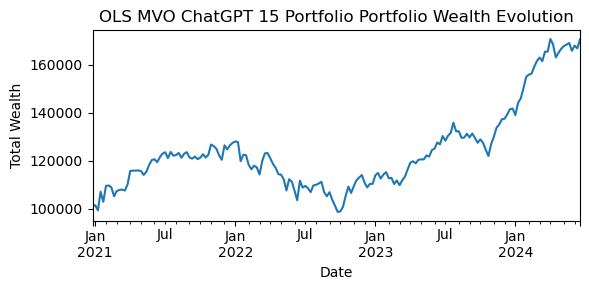

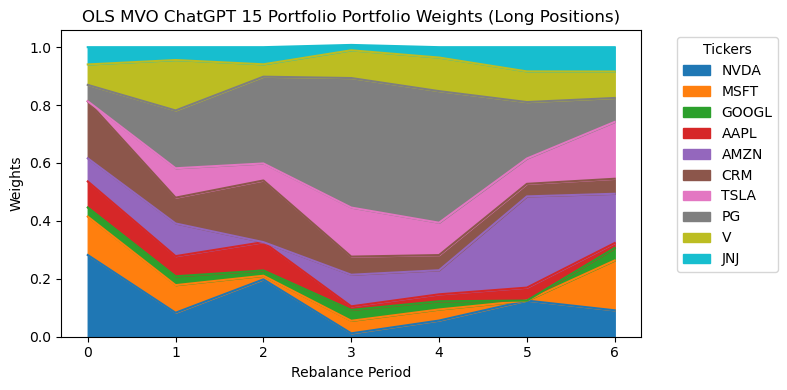

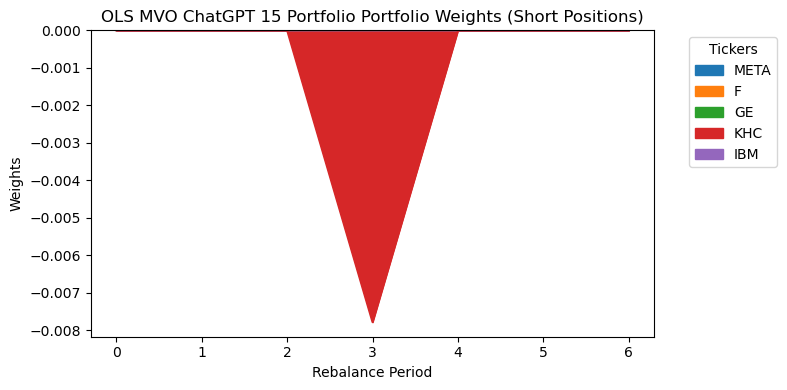

In [11]:
# ChatGPT 15 Stock Portfolio with MVO OLS Weightings
tickersChatGPT15 = [
    'NVDA', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'CRM', 'TSLA', 'PG', 'V', 'JNJ', 'META', 'F', 'GE', 'KHC', 'IBM'
]

shortChatGPT15 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 10 long
    1, 1, 1, 1, 1  # 5 short
]

ChatGPT15Results = test_and_results(tickersChatGPT15, "OLS_MVO_ChatGPT", shortChatGPT15, "", "OLS MVO ChatGPT 15 Portfolio", results)

[*********************100%***********************]  30 of 30 completed


Elasped time is 0.772200345993042 seconds
Sharpe ratio:  0.12266134118952761
Avg. turnover:  0.530176686788766


<Figure size 640x480 with 0 Axes>

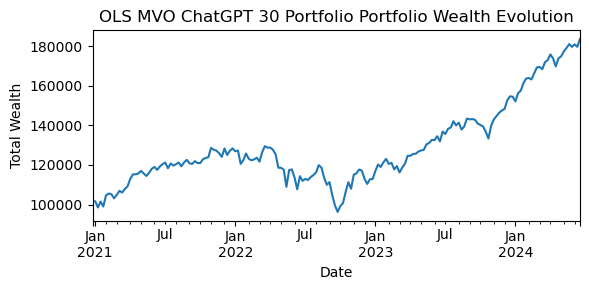

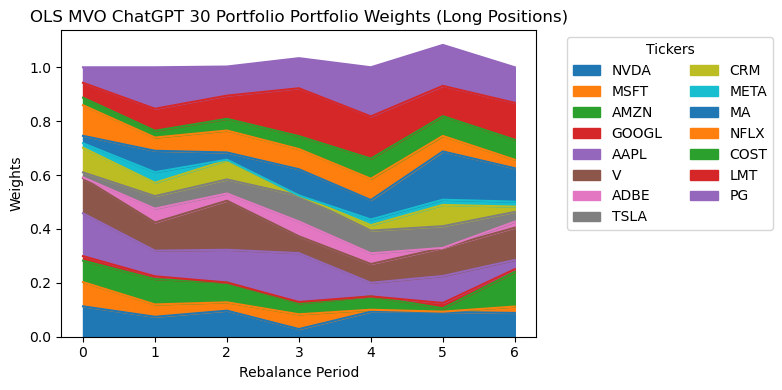

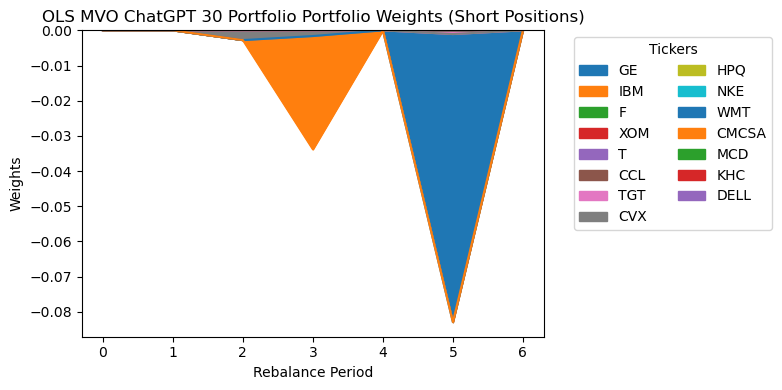

In [12]:
# ChatGPT 30 Stock Portfolio with MVO OLS Weightings
tickersChatGPT30 = [
    'NVDA', 'MSFT', 'AMZN', 'GOOGL', 'AAPL', 'V', 'ADBE', 'TSLA', 'CRM', 'META',
    'MA', 'NFLX', 'COST', 'LMT', 'PG', 'GE', 'IBM', 'F', 'XOM', 'T', 
    'CCL', 'TGT', 'CVX', 'HPQ', 'NKE', 'WMT', 'CMCSA', 'MCD', 'KHC', 'DELL'
]

shortChatGPT30 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 15 long
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 # 15 short
]

ChatGPT30Results = test_and_results(tickersChatGPT30, "OLS_MVO_ChatGPT", shortChatGPT30, "", "OLS MVO ChatGPT 30 Portfolio", results)

[*********************100%***********************]  45 of 45 completed


Elasped time is 0.5160229206085205 seconds
Sharpe ratio:  0.09071169242450011
Avg. turnover:  0.7407028981638053


<Figure size 640x480 with 0 Axes>

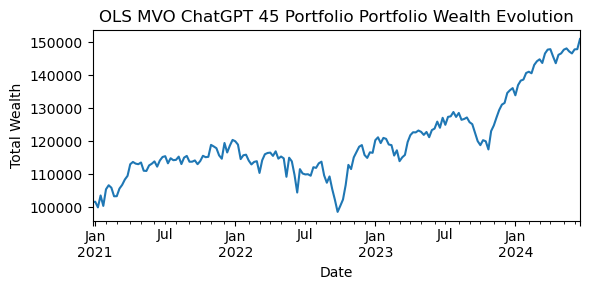

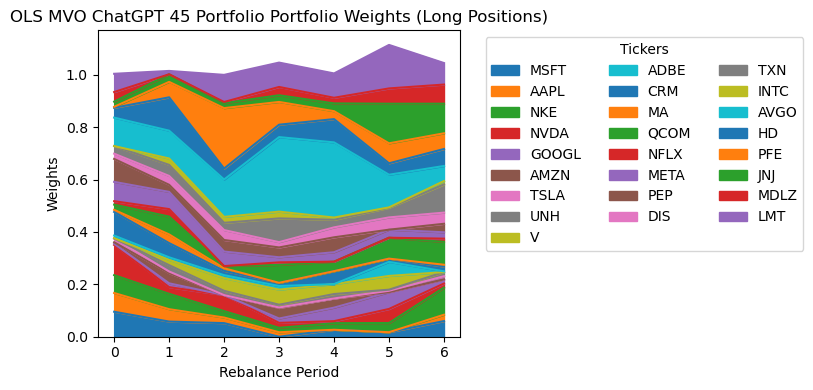

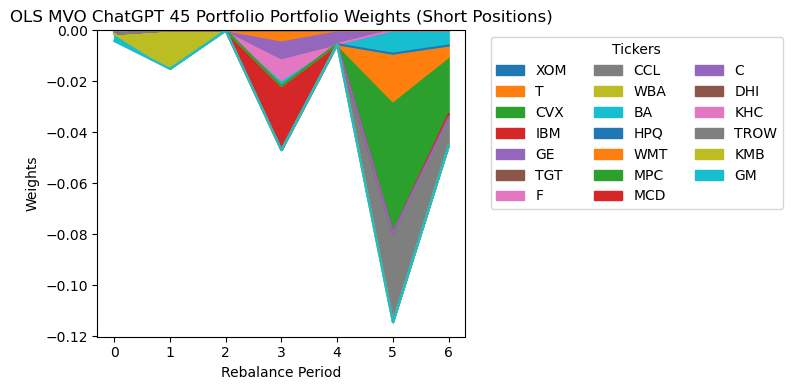

In [13]:
# ChatGPT 45 Stock Portfolio with MVO OLS Weightings
tickersChatGPT45 = [
    'MSFT', 'AAPL', 'NKE', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'UNH', 'V', 'ADBE', 
    'CRM', 'MA', 'QCOM', 'NFLX', 'META', 'PEP', 'DIS', 'TXN', 'INTC', 'AVGO', 
    'HD', 'PFE', 'JNJ', 'MDLZ', 'LMT', 'XOM', 'T', 'CVX', 'IBM', 'GE', 'TGT', 
    'F', 'CCL', 'WBA', 'BA', 'HPQ', 'WMT', 'MPC', 'MCD', 'C', 'DHI', 'KHC', 
    'TROW', 'KMB', 'GM'
]

shortChatGPT45 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 25 long
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1  # 20 short
]

ChatGPT45Results = test_and_results(tickersChatGPT45, "OLS_MVO_ChatGPT", shortChatGPT45, "", "OLS MVO ChatGPT 45 Portfolio", results)

## ChatGPT Weights

[*********************100%***********************]  15 of 15 completed


Elasped time is 0.03487086296081543 seconds
Sharpe ratio:  0.0788137402043958
Avg. turnover:  0.18489674866540204


<Figure size 640x480 with 0 Axes>

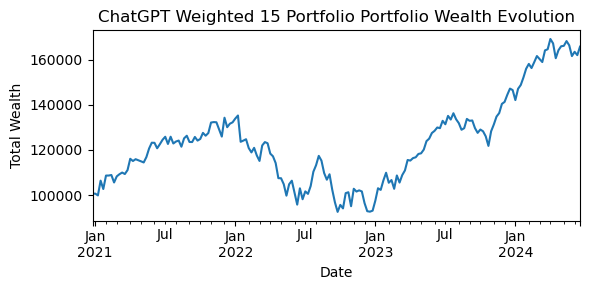

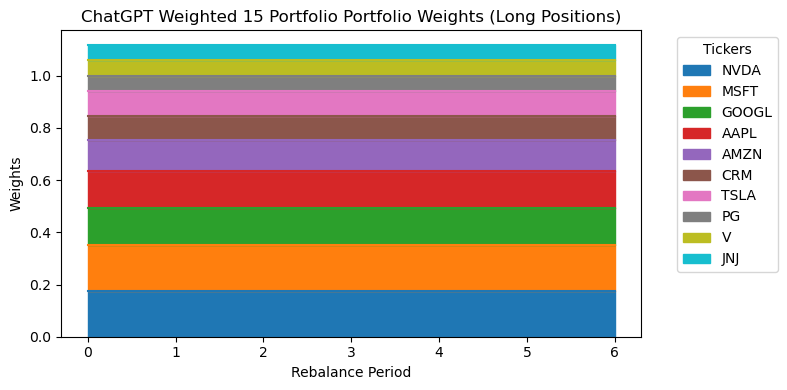

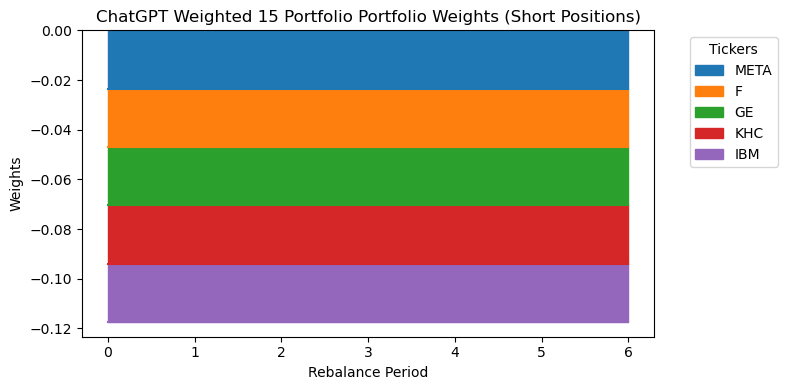

In [14]:
# ChatGPT 15 Stock Portfolio with ChatGPT Weightings
weightsChatGPT15 = [
    0.1765, 0.1765, 0.1412, 0.1412, 0.1176, 0.0941, 0.0941, 0.0588, 0.0588, 0.0588, # 10 long
    -0.0235, -0.0235, -0.0235, -0.0235, -0.0235 # 5 short
]

shortChatGPT15 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 10 long
    1, 1, 1, 1, 1  # 5 short
]

ChatGPT15WeightsResults = test_and_results(tickersChatGPT15, "ChatGPT_Weights", shortChatGPT15, weightsChatGPT15, "ChatGPT Weighted 15 Portfolio", results)

[*********************100%***********************]  30 of 30 completed


Elasped time is 0.05322694778442383 seconds
Sharpe ratio:  0.03538089380604537
Avg. turnover:  0.28286318270504346


<Figure size 640x480 with 0 Axes>

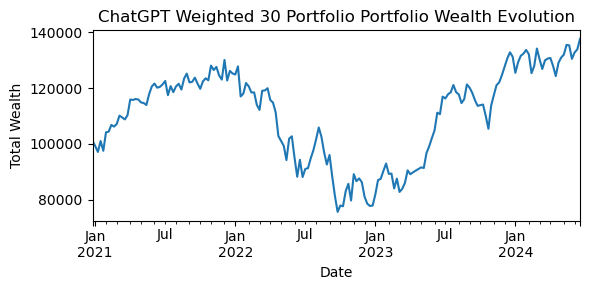

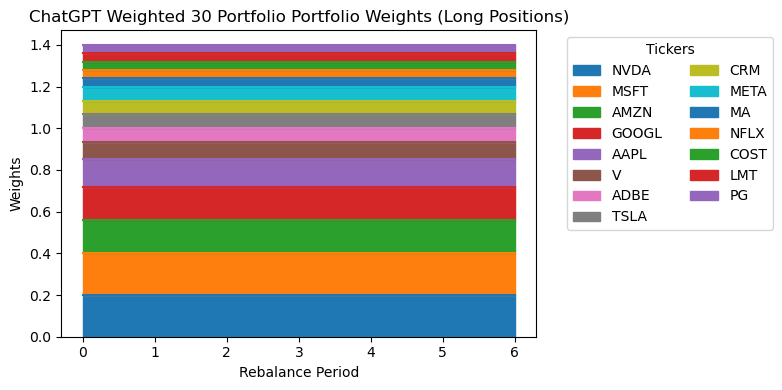

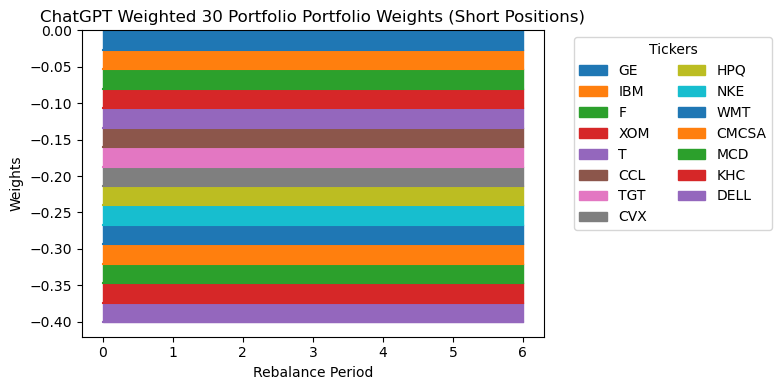

In [15]:
# ChatGPT 30 Stock Portfolio with ChatGPT Weightings
weightsChatGPT30 = [
    0.2000, 0.2000, 0.1600, 0.1600, 0.1333, 0.0800, 0.0667, 0.0667, 
    0.0667, 0.0667, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, -0.0267, # 15 long
    -0.0267, -0.0267, -0.0267, -0.0267, -0.0267, -0.0267, -0.0267, 
    -0.0267, -0.0267, -0.0267, -0.0267, -0.0267, -0.0267, -0.0267 # 15 short
]

shortChatGPT30 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 15 long
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 # 15 short
]

ChatGPT30WeightsResults = test_and_results(tickersChatGPT30, "ChatGPT_Weights", shortChatGPT30, weightsChatGPT30, "ChatGPT Weighted 30 Portfolio", results)

[*********************100%***********************]  45 of 45 completed


Elasped time is 0.025634050369262695 seconds
Sharpe ratio:  0.04234445575484028
Avg. turnover:  0.31119736760811495


<Figure size 640x480 with 0 Axes>

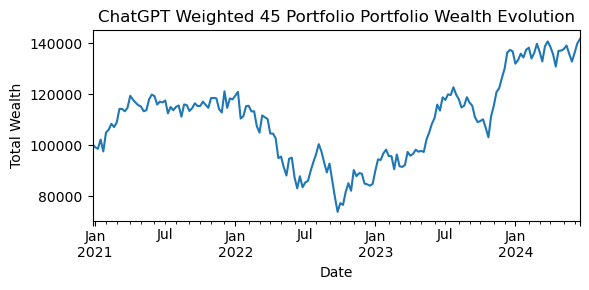

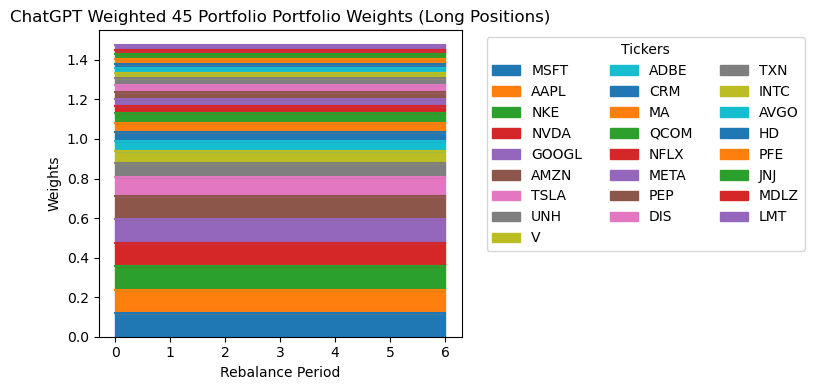

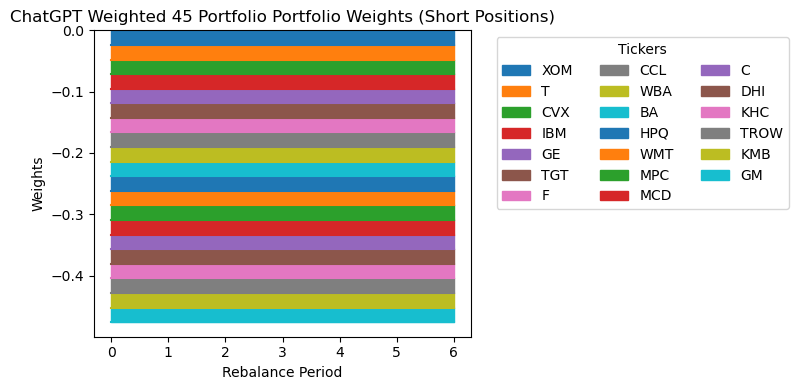

In [16]:
# ChatGPT 45 Stock Portfolio with ChatGPT Weightings
weightsChatGPT45 = [
    0.1190, 0.1190, 0.1190, 0.1190, 0.1190, 0.1190, 0.0952, 0.0714, 
    0.0595, 0.0476, 0.0476, 0.0476, 0.0476, 0.0357, 0.0357, 0.0357, 
    0.0357, 0.0357, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, 0.0238, # 25 long
    -0.0238, -0.0238, -0.0238, -0.0238, -0.0238, -0.0238, 
    -0.0238, -0.0238, -0.0238, -0.0238, -0.0238, -0.0238, -0.0238, 
    -0.0238, -0.0238, -0.0238, -0.0238, -0.0238, -0.0238, -0.0238 # 20 short
]

shortChatGPT45 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 25 long
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1  # 20 short
]

ChatGPT45WeightsResults = test_and_results(tickersChatGPT45, "ChatGPT_Weights", shortChatGPT45, weightsChatGPT45, "ChatGPT Weighted 45 Portfolio", results)

## Robust MVO

[*********************100%***********************]  15 of 15 completed


Elasped time is 0.26435303688049316 seconds
Sharpe ratio:  0.10574340273155046
Avg. turnover:  0.5168060322668743


<Figure size 640x480 with 0 Axes>

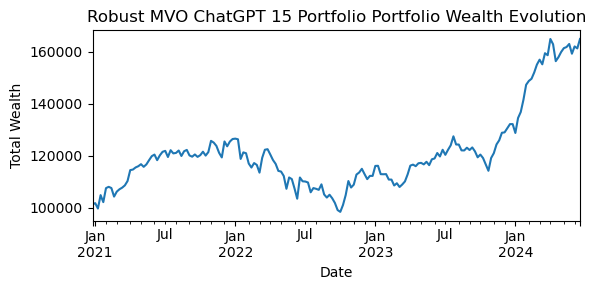

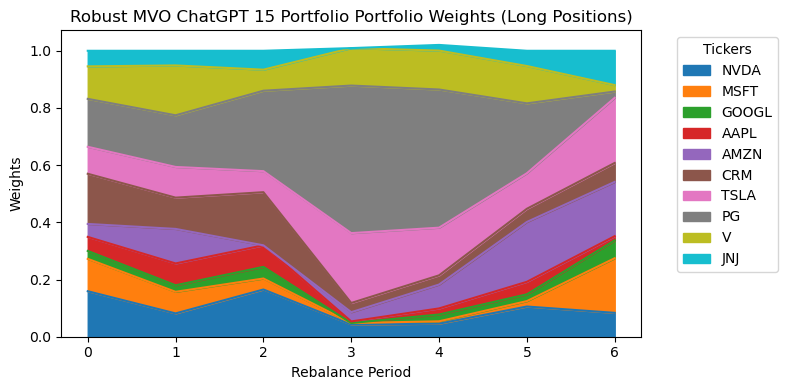

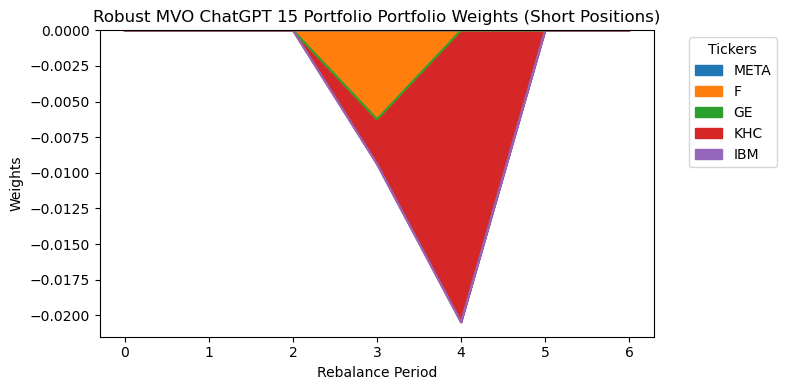

In [17]:
# ChatGPT 15 Stock Portfolio with Robust MVO OLS Weightings
tickersChatGPT15 = [
    'NVDA', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'CRM', 'TSLA', 'PG', 'V', 'JNJ', 'META', 'F', 'GE', 'KHC', 'IBM'
]

shortChatGPT15 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 10 long
    1, 1, 1, 1, 1  # 5 short
]

RobustMVO15Results = test_and_results(tickersChatGPT15, "OLS_Robust_MVO_ChatGPT", shortChatGPT15, "", "Robust MVO ChatGPT 15 Portfolio", results)

[*********************100%***********************]  30 of 30 completed


Elasped time is 0.4025566577911377 seconds
Sharpe ratio:  0.12195076819340284
Avg. turnover:  0.6601100921552419


<Figure size 640x480 with 0 Axes>

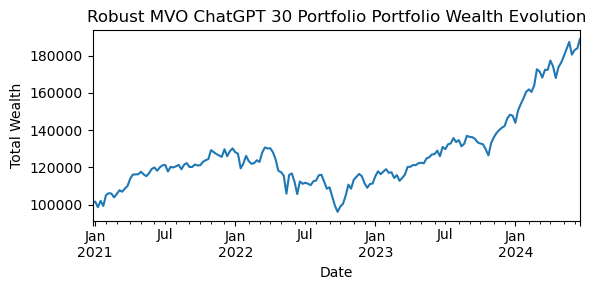

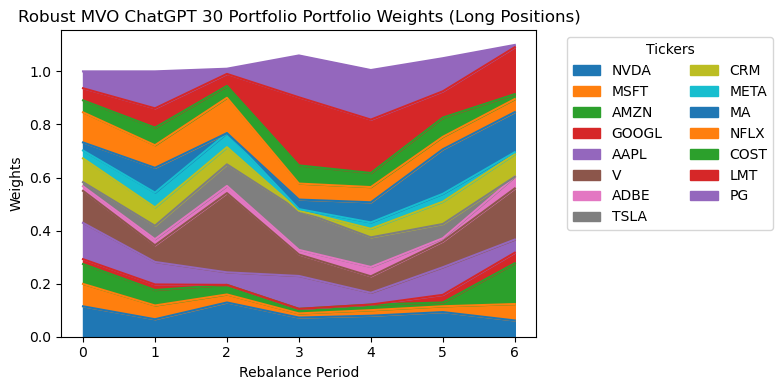

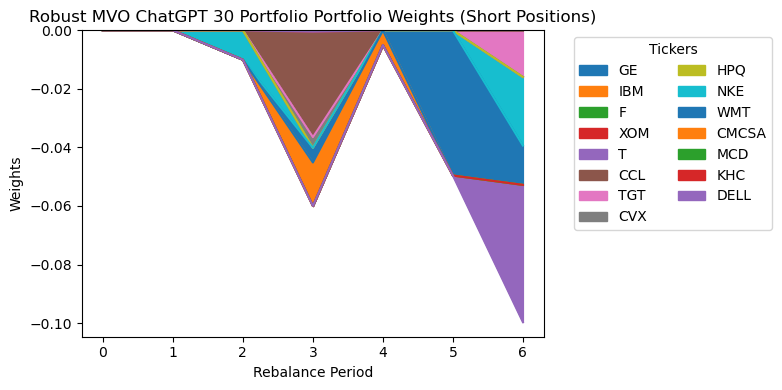

In [18]:
# ChatGPT 30 Stock Portfolio with Robust MVO OLS Weightings
tickersChatGPT30 = [
    'NVDA', 'MSFT', 'AMZN', 'GOOGL', 'AAPL', 'V', 'ADBE', 'TSLA', 'CRM', 'META',
    'MA', 'NFLX', 'COST', 'LMT', 'PG', 'GE', 'IBM', 'F', 'XOM', 'T', 
    'CCL', 'TGT', 'CVX', 'HPQ', 'NKE', 'WMT', 'CMCSA', 'MCD', 'KHC', 'DELL'
]

shortChatGPT30 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 15 long
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 # 15 short
]

RobustMVO30Results = test_and_results(tickersChatGPT30, "OLS_Robust_MVO_ChatGPT", shortChatGPT30, "", "Robust MVO ChatGPT 30 Portfolio", results)

[*********************100%***********************]  45 of 45 completed


Elasped time is 0.5064775943756104 seconds
Sharpe ratio:  0.09382289184668616
Avg. turnover:  0.9900839447633509


<Figure size 640x480 with 0 Axes>

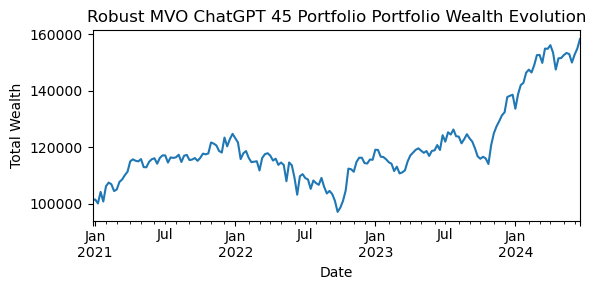

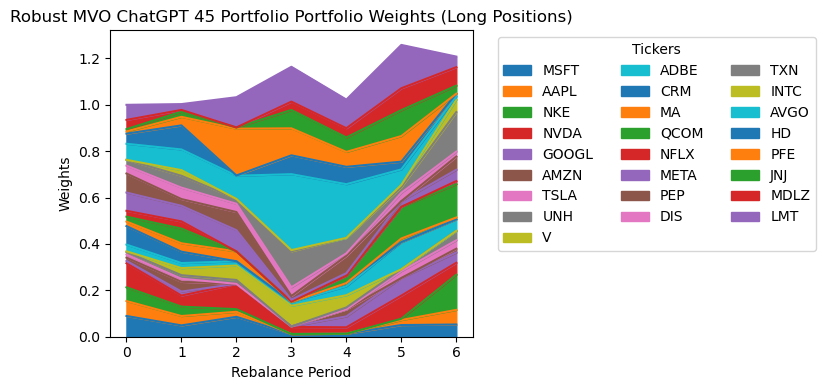

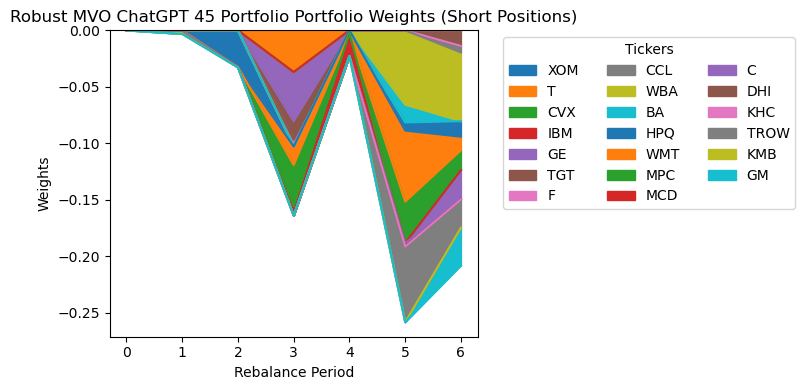

In [19]:
# ChatGPT 45 Stock Portfolio with Robust MVO OLS Weightings
tickersChatGPT45 = [
    'MSFT', 'AAPL', 'NKE', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'UNH', 'V', 'ADBE', 
    'CRM', 'MA', 'QCOM', 'NFLX', 'META', 'PEP', 'DIS', 'TXN', 'INTC', 'AVGO', 
    'HD', 'PFE', 'JNJ', 'MDLZ', 'LMT', 'XOM', 'T', 'CVX', 'IBM', 'GE', 'TGT', 
    'F', 'CCL', 'WBA', 'BA', 'HPQ', 'WMT', 'MPC', 'MCD', 'C', 'DHI', 'KHC', 
    'TROW', 'KMB', 'GM'
]

shortChatGPT45 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 25 long
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1  # 20 short
]

RobustMVO45Results = test_and_results(tickersChatGPT45, "OLS_Robust_MVO_ChatGPT", shortChatGPT45, "", "Robust MVO ChatGPT 45 Portfolio", results)

In [20]:
# export the results of the optimization
results.to_csv('optimization_results.csv')

## CVAR

[*********************100%***********************]  15 of 15 completed


                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 22 05:02:49 PM: Your problem has 52 variables, 96 constraints, and 0 parameters.
(CVXPY) Nov 22 05:02:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 22 05:02:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 22 05:02:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 22 05:02:49 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 22 05:02:49 PM: Compiling problem (target solver=ECOS).
(CV

c:\Users\matth\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\matth\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


(CVXPY) Nov 22 05:02:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 22 05:02:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 22 05:02:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 22 05:02:49 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 22 05:02:49 PM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 22 05:02:49 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Nov 22 05:02:49 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 22 05:02:49 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 22 05:02:49 PM: Applying

<Figure size 640x480 with 0 Axes>

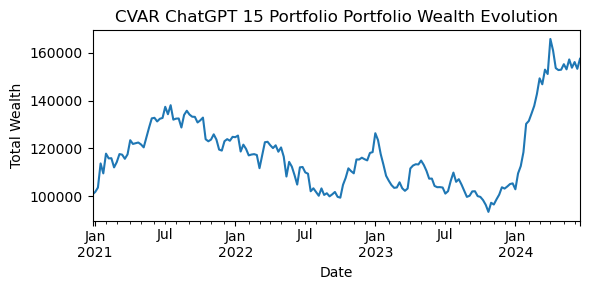

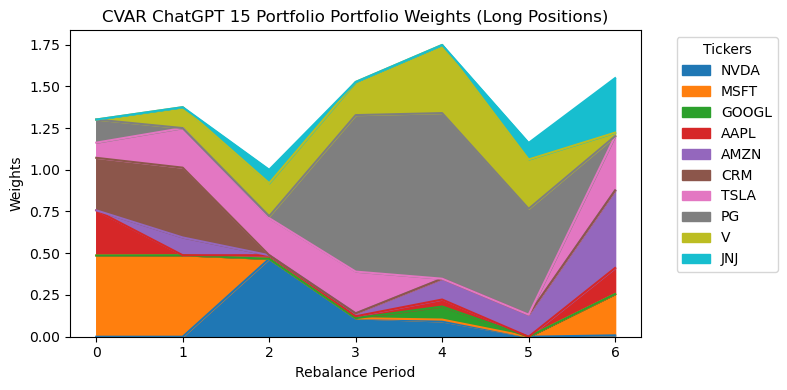

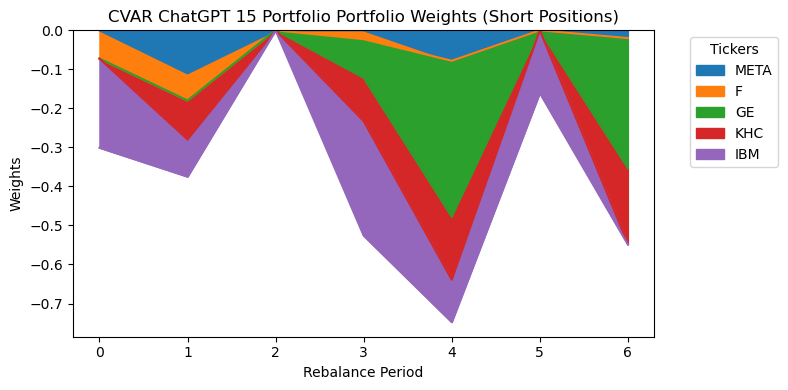

In [21]:
# ChatGPT 15 Stock Portfolio with CVAR Weightings
tickersChatGPT15 = [
    'NVDA', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'CRM', 'TSLA', 'PG', 'V', 'JNJ', 'META', 'F', 'GE', 'KHC', 'IBM'
]

shortChatGPT15 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 10 long
    1, 1, 1, 1, 1  # 5 short
]

CVAR15Results = test_and_results(tickersChatGPT15, "OLS_CVAR_ChatGPT", shortChatGPT15, "", "CVAR ChatGPT 15 Portfolio", results)

[*********************100%***********************]  30 of 30 completed


                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 22 05:02:58 PM: Your problem has 67 variables, 111 constraints, and 0 parameters.
(CVXPY) Nov 22 05:02:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 22 05:02:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 22 05:02:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 22 05:02:58 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 22 05:02:58 PM: Compiling problem (target solver=ECOS).
(C

c:\Users\matth\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\matth\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


(CVXPY) Nov 22 05:02:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 22 05:02:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 22 05:02:58 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 22 05:02:58 PM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 22 05:02:58 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Nov 22 05:02:58 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 22 05:02:58 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 22 05:02:58 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Nov 22 05:02:58 PM: Applying reduction ECOS
(

<Figure size 640x480 with 0 Axes>

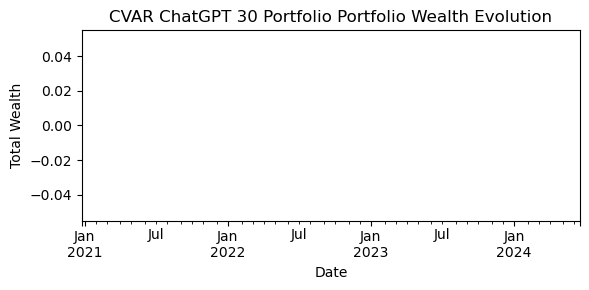

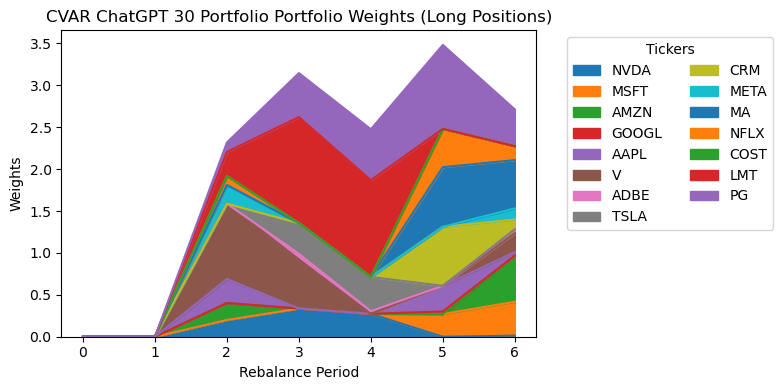

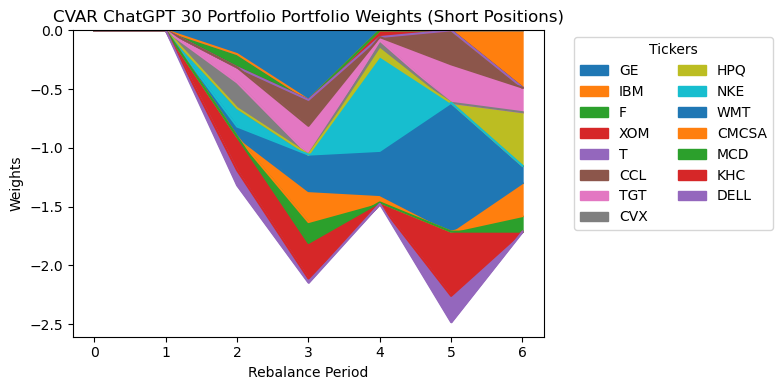

In [22]:
# ChatGPT 30 Stock Portfolio with CVAR Weightings
tickersChatGPT30 = [
    'NVDA', 'MSFT', 'AMZN', 'GOOGL', 'AAPL', 'V', 'ADBE', 'TSLA', 'CRM', 'META',
    'MA', 'NFLX', 'COST', 'LMT', 'PG', 'GE', 'IBM', 'F', 'XOM', 'T', 
    'CCL', 'TGT', 'CVX', 'HPQ', 'NKE', 'WMT', 'CMCSA', 'MCD', 'KHC', 'DELL'
]

shortChatGPT30 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 15 long
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 # 15 short
]

CVAR30Results = test_and_results(tickersChatGPT30, "OLS_CVAR_ChatGPT", shortChatGPT30, "", "CVAR ChatGPT 30 Portfolio", results)

[*********************100%***********************]  45 of 45 completed


                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Nov 22 05:03:09 PM: Your problem has 82 variables, 126 constraints, and 0 parameters.
(CVXPY) Nov 22 05:03:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 22 05:03:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 22 05:03:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 22 05:03:09 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 22 05:03:09 PM: Compiling problem (target solver=ECOS).
(C

c:\Users\matth\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\matth\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 22 05:03:09 PM: Compiling problem (target solver=ECOS).
(CVXPY) Nov 22 05:03:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Nov 22 05:03:09 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 22 05:03:09 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 22 05:03:09 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Nov 22 05:03:09 PM: Applying reduction ECOS
(CVXPY) Nov 22 05:03:09 PM: Finished problem compilation (took 7.310e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Nov 22 05:03:09 PM: Inv

<Figure size 640x480 with 0 Axes>

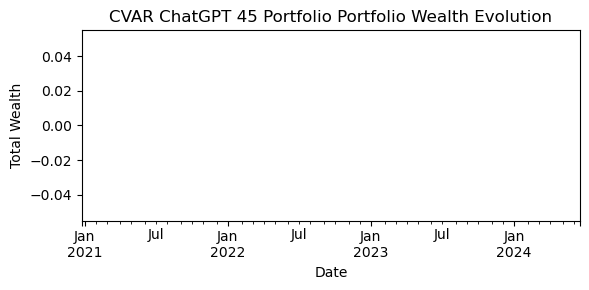

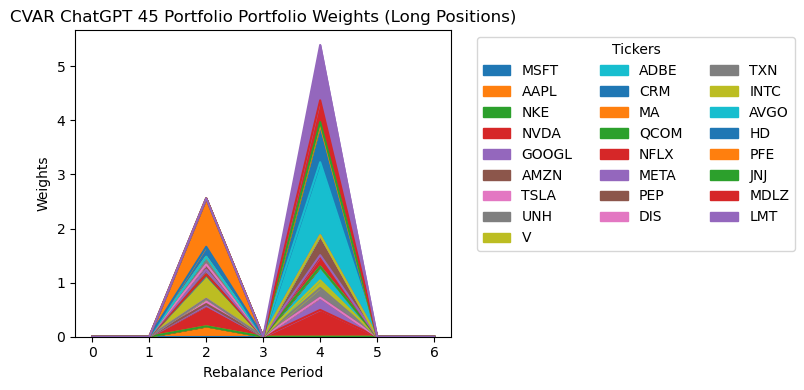

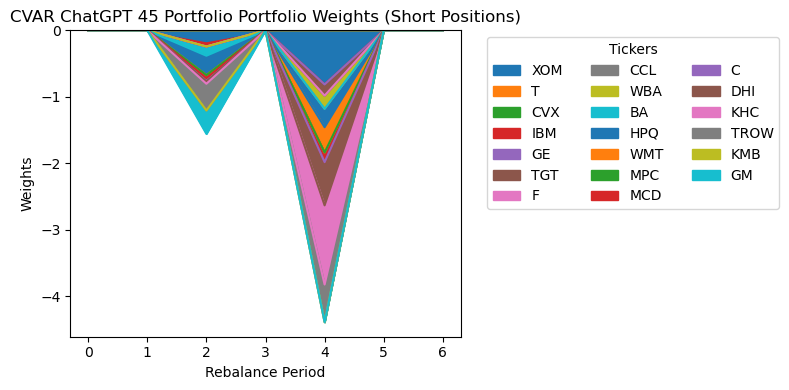

In [23]:
# ChatGPT 45 Stock Portfolio with CVAR Weightings
tickersChatGPT45 = [
    'MSFT', 'AAPL', 'NKE', 'NVDA', 'GOOGL', 'AMZN', 'TSLA', 'UNH', 'V', 'ADBE', 
    'CRM', 'MA', 'QCOM', 'NFLX', 'META', 'PEP', 'DIS', 'TXN', 'INTC', 'AVGO', 
    'HD', 'PFE', 'JNJ', 'MDLZ', 'LMT', 'XOM', 'T', 'CVX', 'IBM', 'GE', 'TGT', 
    'F', 'CCL', 'WBA', 'BA', 'HPQ', 'WMT', 'MPC', 'MCD', 'C', 'DHI', 'KHC', 
    'TROW', 'KMB', 'GM'
]

shortChatGPT45 = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # 25 long
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1  # 20 short
]

CVAR45Results = test_and_results(tickersChatGPT45, "OLS_CVAR_ChatGPT", shortChatGPT45, "", "CVAR ChatGPT 45 Portfolio", results)